# 케라스 전이 학습(Transfer Learning)

<img src="https://miro.medium.com/max/5252/1*Z11P-CjNYWBofEbmGQrptA.png">

<sub>출처: https://medium.com/the-official-integrate-ai-blog/transfer-learning-explained-7d275c1e34e2</sub>


In [12]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.applications import *

In [13]:
vgg16 = VGG16(
    weights='imagenet',
    input_shape=(32, 32, 3),
    include_top=False
)

In [14]:
model = Sequential()
model.add(vgg16)

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_5 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                      

In [15]:
mobilenet = MobileNet(
    weights=None,
    input_shape=None,
    include_top=True
)
resnest = ResNet50(
    weights=None,
    input_shape=None,
    include_top=True
)
xception = Xception(
    weights=None,
    input_shape=None,
    include_top=True
)

### 예제 : Dogs vs Cats
- Kaggle Data 이용: https://www.kaggle.com/c/dogs-vs-cats/data

- ImageDataGenerator의 flow_from_directory 이용

- 런타임 유형 GPU 사용

- 출처: https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part2.ipynb#scrollTo=SdW6geEVi2S8

#### modules import

In [16]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.layers import Conv2D, Flatten, MaxPool2D, Input, Dropout, Dense
from keras.models import Model
from keras.optimizers import Adam

import os
import zipfile
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import requests

#### 데이터 로드

In [17]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
dir_name = 'data'
file_name = 'cats_and_dogs_filtered'
file_path = os.path.join(dir_name, f'{file_name}.zip')

os.makedirs(dir_name, exist_ok=True)

response = requests.get(URL)
with open(file_path, 'wb') as f:
    f.write(response.content)

In [19]:
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    extract_path = os.path.join('.', dir_name)
    zip_ref.extractall(extract_path)

In [20]:
base_dir = os.path.join(dir_name, file_name)
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [22]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

#### 이미지 보강된 데이터 확인

In [24]:
from keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

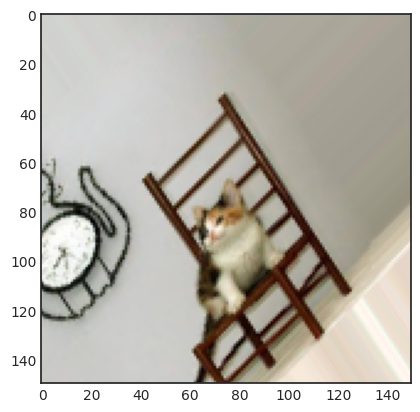

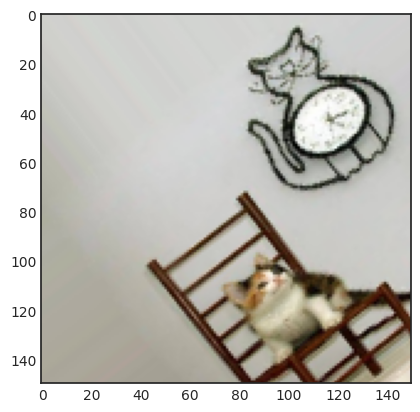

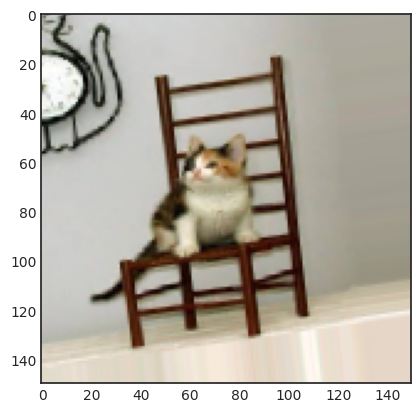

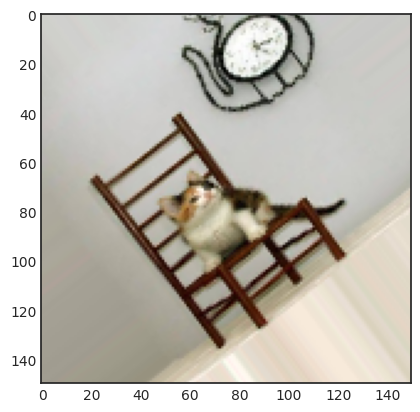

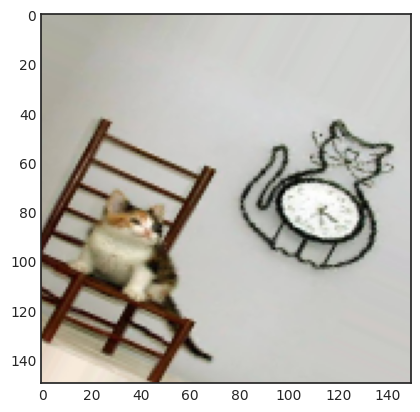

In [28]:
import numpy as np

img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)
x = x[np.newaxis, :]

for i, batch in enumerate(data_gen.flow(x, batch_size=1)):
    plt.figure(i)
    img_plot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 5 == 0:
        break

#### 학습, 검증 데이터셋의 Data Generator

In [29]:
train_data_gen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
)
train_gen = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

val_data_gen = ImageDataGenerator(rescale=1/255)
val_gen = val_data_gen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 모델 구성 및 컴파일

In [32]:
model = Sequential()
model.add(Input(shape=(150, 150, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D(2, 2))

model.add(Flatten())
model.add(Dropout(.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 128)      

#### 모델 학습 및 학습 과정 시각화
- 런타임유형 GPU 사용

In [33]:
hist = model.fit(
    train_gen,
    steps_per_epoch=100,
    epochs=50,
    batch_size=256,
    validation_data=val_gen,
    validation_steps=50,
    verbose=2
)

Epoch 1/50


2024-01-15 17:14:31.158209: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-01-15 17:14:31.357871: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-15 17:14:32.098420: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-15 17:14:33.627013: I external/local_xla/xla/service/service.cc:168] XLA service 0x7febe5f59b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-15 17:14:33.627056: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-01-15 17:14:33.641670: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705306473.748238   28098 device_compil

100/100 - 13s - loss: 0.6890 - accuracy: 0.5425 - val_loss: 0.6618 - val_accuracy: 0.5620 - 13s/epoch - 130ms/step
Epoch 2/50
100/100 - 8s - loss: 0.6646 - accuracy: 0.5830 - val_loss: 0.6334 - val_accuracy: 0.6170 - 8s/epoch - 80ms/step
Epoch 3/50
100/100 - 8s - loss: 0.6440 - accuracy: 0.6180 - val_loss: 0.6208 - val_accuracy: 0.6630 - 8s/epoch - 78ms/step
Epoch 4/50
100/100 - 8s - loss: 0.6320 - accuracy: 0.6315 - val_loss: 0.5946 - val_accuracy: 0.6980 - 8s/epoch - 80ms/step
Epoch 5/50
100/100 - 8s - loss: 0.6141 - accuracy: 0.6610 - val_loss: 0.6076 - val_accuracy: 0.6370 - 8s/epoch - 81ms/step
Epoch 6/50
100/100 - 8s - loss: 0.5994 - accuracy: 0.6690 - val_loss: 0.5817 - val_accuracy: 0.6760 - 8s/epoch - 81ms/step
Epoch 7/50
100/100 - 8s - loss: 0.5930 - accuracy: 0.6795 - val_loss: 0.5536 - val_accuracy: 0.7160 - 8s/epoch - 80ms/step
Epoch 8/50
100/100 - 8s - loss: 0.5828 - accuracy: 0.6880 - val_loss: 0.6070 - val_accuracy: 0.6570 - 8s/epoch - 79ms/step
Epoch 9/50
100/100 - 8s 

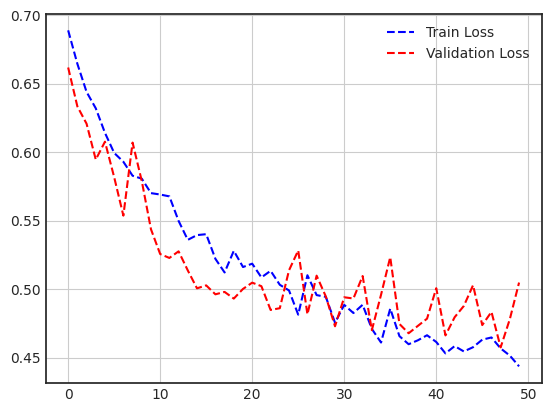

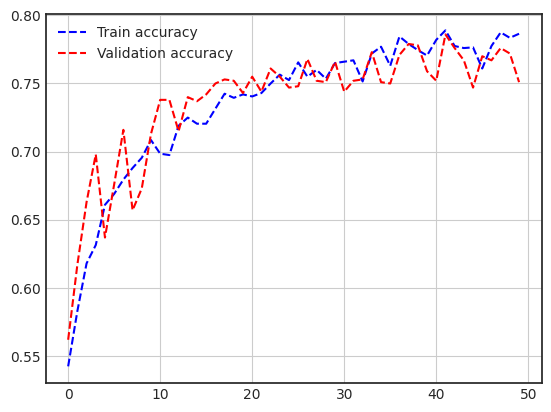

In [38]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']
epochs = range(len(accuracy))

plt.plot(epochs, loss, 'b--', label='Train Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, accuracy, 'b--', label='Train accuracy')
plt.plot(epochs, val_accuracy, 'r--', label='Validation accuracy')
plt.grid()
plt.legend()

plt.show()

#### 모델 저장

In [39]:
model.save('cats_and_dogs_model.h5')

/root/miniconda3/envs/tf_gpu/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 사전 훈련된 모델 사용

In [40]:
conv_base = VGG16(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
)

In [43]:
from keras.optimizers import RMSprop

def build_model_with_pretrained(conv_base):
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=RMSprop(learning_rate=2e-5),
        metrics=['accuracy']
    )

    return model

파라미터의 수 확인!

In [44]:
model = build_model_with_pretrained(conv_base)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               2097408   
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### 레이어 동결
- 훈련하기 전, 합성곱 기반 레이어들의 가중치 학습을 막기 위해 이를 동결

In [45]:
print(len(model.trainable_weights))

30


In [46]:
conv_base.trainable = False

print(len(model.trainable_weights))

4


#### 모델 컴파일
- trainable 속성을 변경했기 때문에 다시 모델을 컴파일 해야함

In [47]:
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=2e-5),
    metrics=['accuracy']
)

#### 이미지 제너레이터

In [48]:
train_data_gen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
)
train_gen = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

val_data_gen = ImageDataGenerator(rescale=1/255)
val_gen = val_data_gen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### 모델 재학습

In [49]:
hist_2 = model.fit(
    train_gen,
    steps_per_epoch=100,
    epochs=50,
    batch_size=256,
    validation_data=val_gen,
    validation_steps=50,
    verbose=2
)

Epoch 1/50


2024-01-15 17:30:25.820023: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 235.87MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-15 17:30:25.820206: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 235.87MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-15 17:30:25.830506: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 345.78MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-15 17:30:25.830589: W external/local_tsl/tsl/framewor

100/100 - 11s - loss: 0.6166 - accuracy: 0.6610 - val_loss: 0.4599 - val_accuracy: 0.8190 - 11s/epoch - 109ms/step
Epoch 2/50
100/100 - 9s - loss: 0.4988 - accuracy: 0.7725 - val_loss: 0.3769 - val_accuracy: 0.8450 - 9s/epoch - 89ms/step
Epoch 3/50
100/100 - 9s - loss: 0.4310 - accuracy: 0.8110 - val_loss: 0.3386 - val_accuracy: 0.8530 - 9s/epoch - 87ms/step
Epoch 4/50
100/100 - 9s - loss: 0.4079 - accuracy: 0.8205 - val_loss: 0.3121 - val_accuracy: 0.8630 - 9s/epoch - 92ms/step
Epoch 5/50
100/100 - 9s - loss: 0.3831 - accuracy: 0.8315 - val_loss: 0.3002 - val_accuracy: 0.8610 - 9s/epoch - 90ms/step
Epoch 6/50
100/100 - 9s - loss: 0.3587 - accuracy: 0.8400 - val_loss: 0.2919 - val_accuracy: 0.8660 - 9s/epoch - 90ms/step
Epoch 7/50
100/100 - 9s - loss: 0.3595 - accuracy: 0.8430 - val_loss: 0.2880 - val_accuracy: 0.8730 - 9s/epoch - 90ms/step
Epoch 8/50
100/100 - 9s - loss: 0.3529 - accuracy: 0.8415 - val_loss: 0.2764 - val_accuracy: 0.8720 - 9s/epoch - 91ms/step
Epoch 9/50
100/100 - 9s 

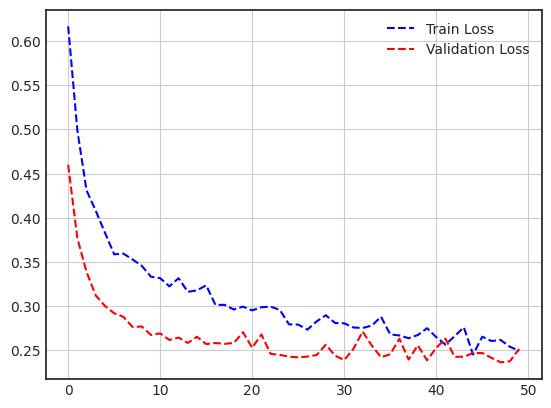

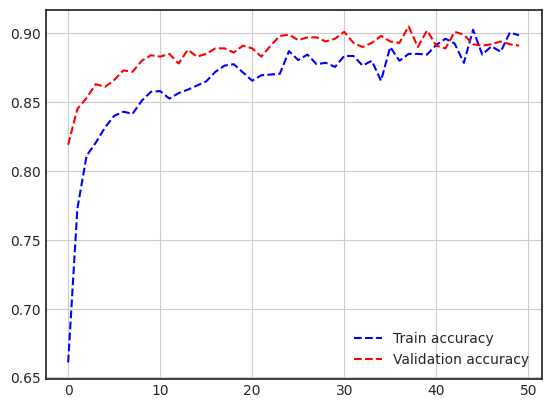

In [50]:
loss = hist_2.history['loss']
val_loss = hist_2.history['val_loss']
accuracy = hist_2.history['accuracy']
val_accuracy = hist_2.history['val_accuracy']
epochs = range(len(accuracy))

plt.plot(epochs, loss, 'b--', label='Train Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, accuracy, 'b--', label='Train accuracy')
plt.plot(epochs, val_accuracy, 'r--', label='Validation accuracy')
plt.grid()
plt.legend()

plt.show()

#### 모델 저장

In [51]:
model.save('cats_and_dogs_with_pretrained_model.h5')

/root/miniconda3/envs/tf_gpu/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Feature Map 시각화

In [54]:
from keras.models import load_model
from keras.preprocessing import image

### 모델 구성

In [53]:
model = load_model('./cats_and_dogs_model.h5')

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 128)      

In [58]:
img_path = './data/cats_and_dogs_filtered/validation/dogs/dog.2000.jpg'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = img_tensor[np.newaxis, ...]
img_tensor /= 255

print(img_tensor.shape)

(1, 150, 150, 3)


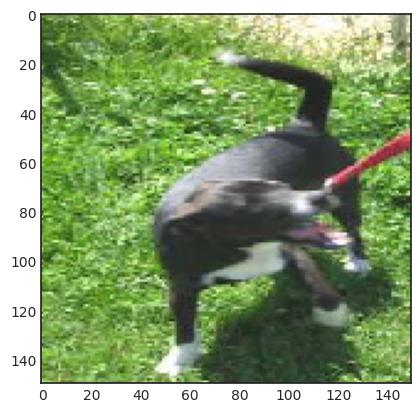

In [60]:
plt.imshow(img_tensor[0])

plt.show()

In [77]:
conv_out = [layer.output for layer in model.layers[:6]]

conv_out

[<KerasTensor: shape=(None, 148, 148, 32) dtype=float32 (created by layer 'conv2d_11')>,
 <KerasTensor: shape=(None, 74, 74, 32) dtype=float32 (created by layer 'max_pooling2d_3')>,
 <KerasTensor: shape=(None, 72, 72, 64) dtype=float32 (created by layer 'conv2d_12')>,
 <KerasTensor: shape=(None, 36, 36, 64) dtype=float32 (created by layer 'max_pooling2d_4')>,
 <KerasTensor: shape=(None, 34, 34, 128) dtype=float32 (created by layer 'conv2d_13')>,
 <KerasTensor: shape=(None, 17, 17, 128) dtype=float32 (created by layer 'max_pooling2d_5')>]

In [78]:
activation_model = Model(inputs=[model.input], outputs=conv_out)

In [79]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 49ms/step


In [80]:
len(activations)

6

### 시각화

(1, 148, 148, 32)


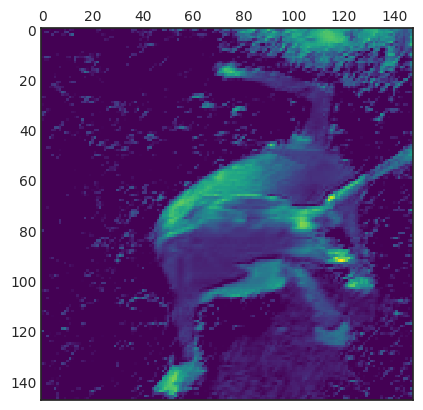

In [65]:
print(activations[0].shape)
plt.matshow(activations[0][0, :, :, 7], cmap='viridis')

plt.show()

(1, 148, 148, 32)


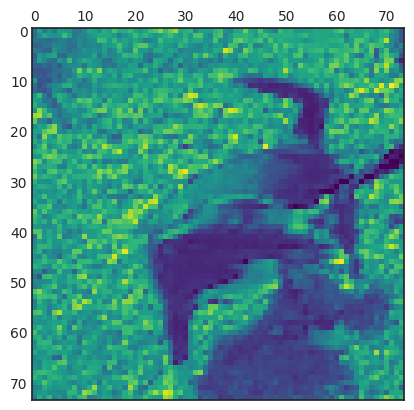

In [71]:
print(activations[0].shape)
plt.matshow(activations[1][0, :, :, 10], cmap='viridis')

plt.show()

(1, 148, 148, 32)


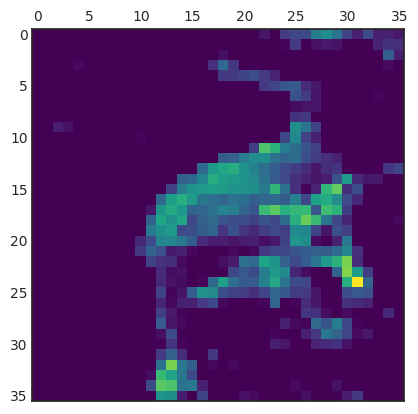

In [68]:
print(activations[0].shape)
plt.matshow(activations[3][0, :, :, 20], cmap='viridis')

plt.show()

### 중간의 모든 활성화에 대해 시각화

/tmp/ipykernel_27871/3583691459.py:21: RuntimeWarning: invalid value encountered in cast
  channel_img = np.clip(channel_img, 0, 255).astype('uint8')


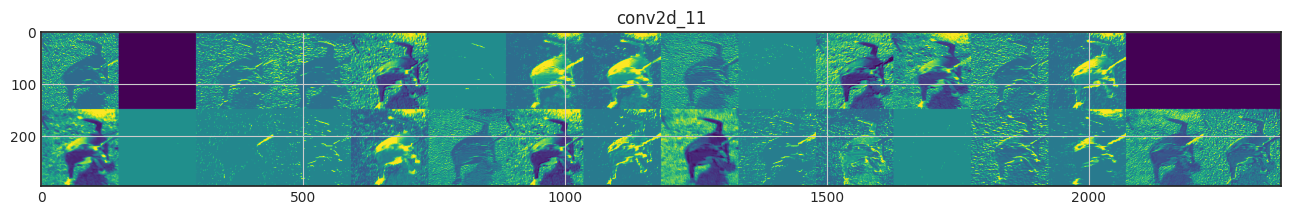

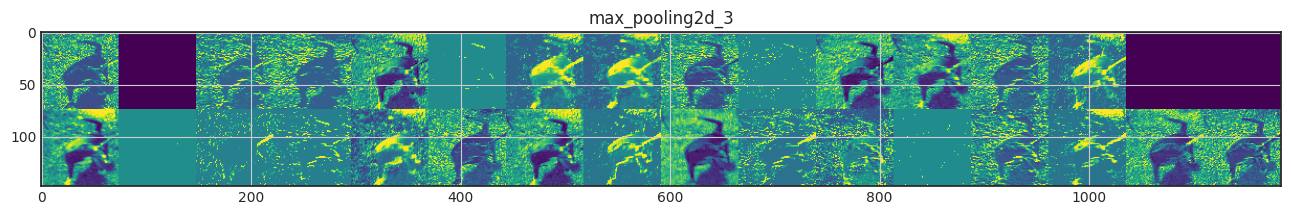

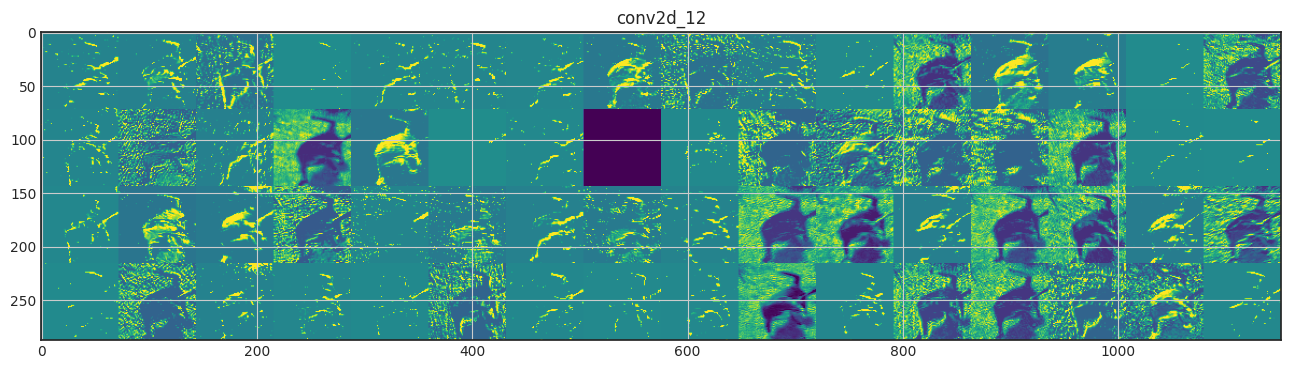

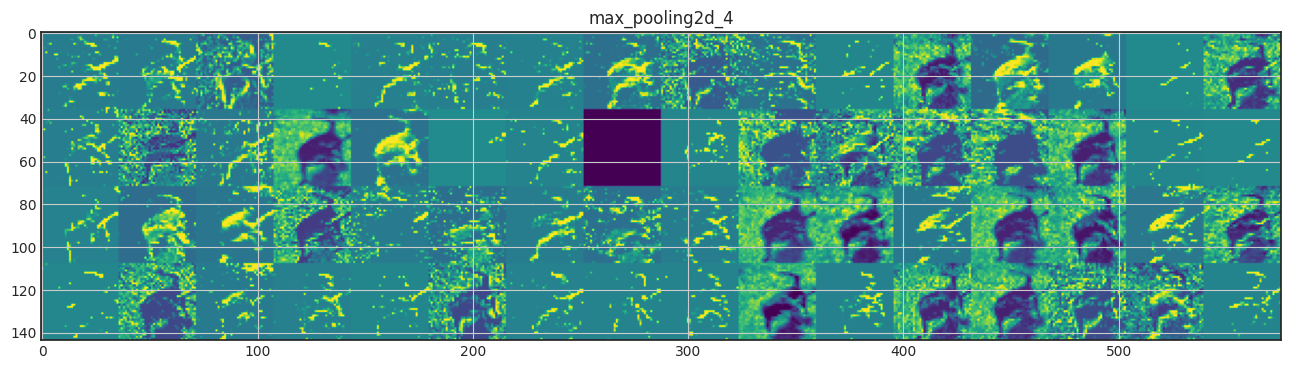

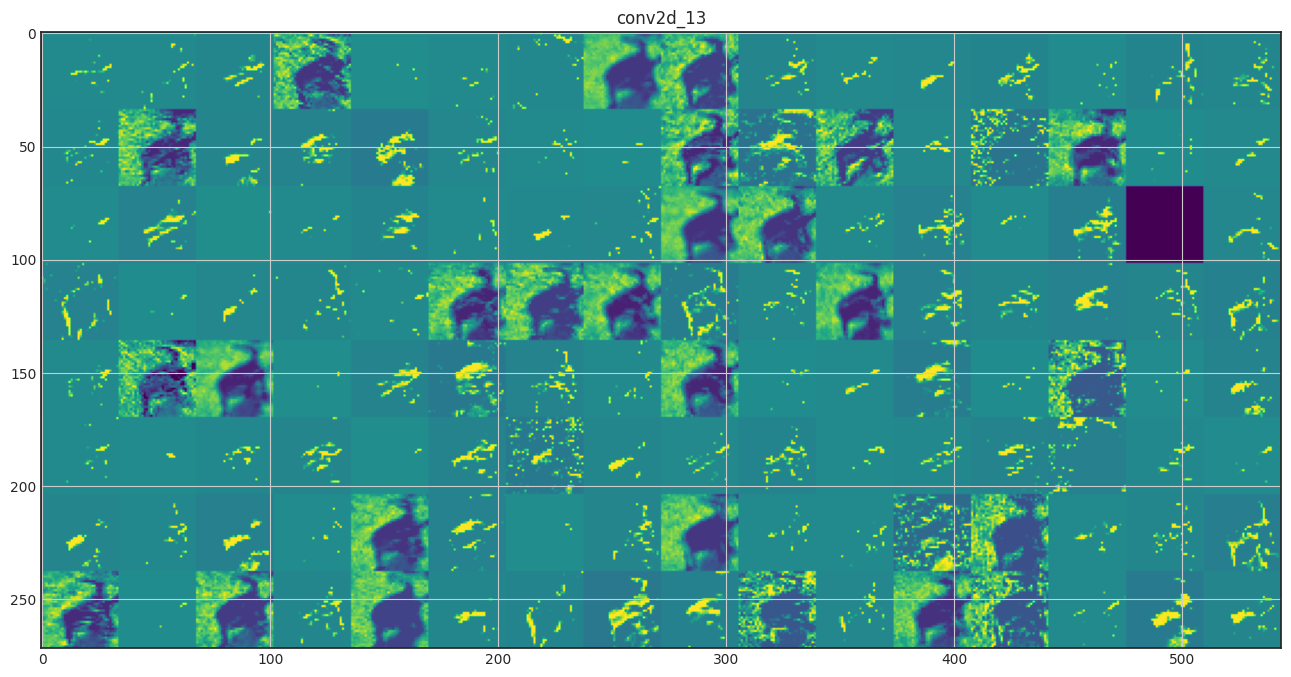

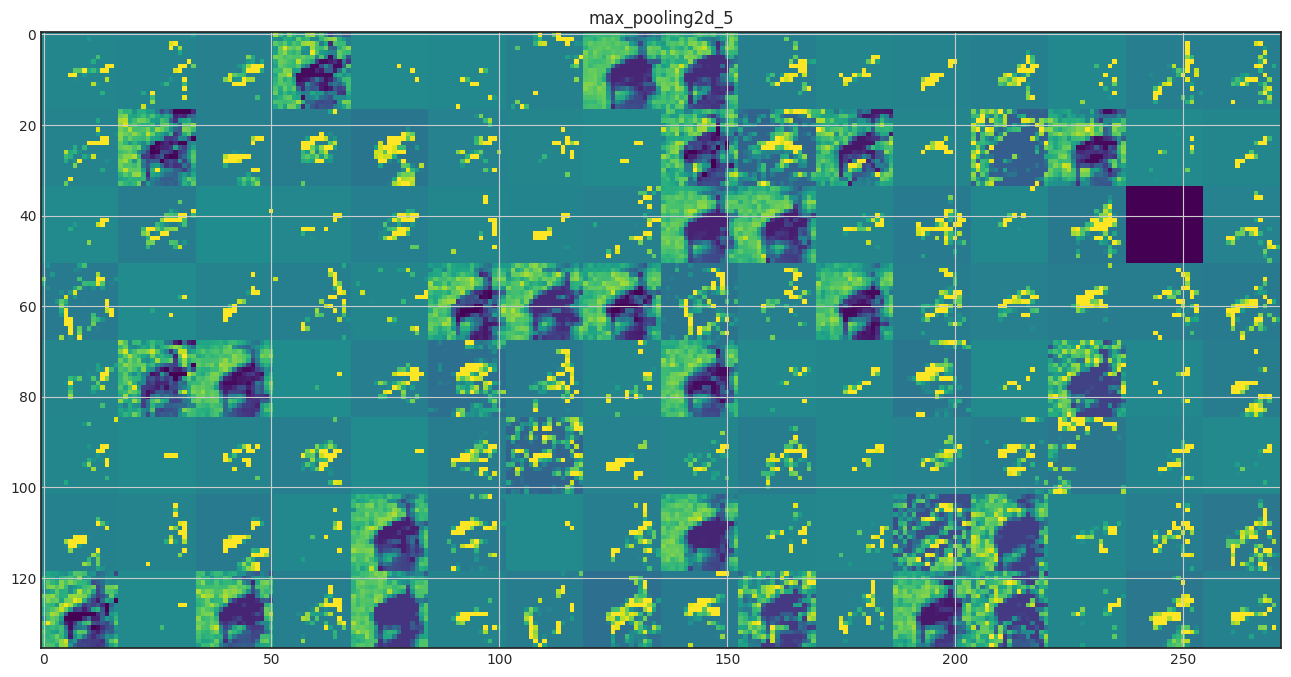

In [82]:
layer_names = []

for layer in model.layers[:8]:
    layer_names.append(layer.name)

imgs_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // imgs_per_row
    display_grid = np.zeros((size * n_cols, imgs_per_row * size))

    for col in range(n_cols):
        for row in range(imgs_per_row):
            channel_img = layer_activation[0, :, :, col * imgs_per_row + row]
            channel_img -= channel_img.mean()
            channel_img /= channel_img.std()
            channel_img *= 64
            channel_img += 128
            channel_img = np.clip(channel_img, 0, 255).astype('uint8')
            display_grid[col * size:(col + 1) * size, row * size:(row + 1) * size] = channel_img
    
    scale = 1 / size

    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid()
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()